In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

1.826212606557199e-05


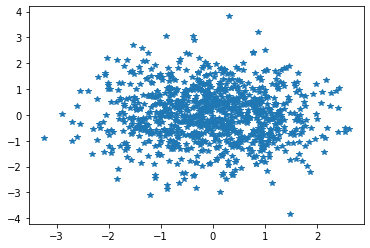

In [11]:
x= []
y = []
for i in range(1000):
    x.append(np.random.normal(0,1))
    y.append(np.random.normal(0,1))
plt.plot(x, y, '*')
plt.show()